<a id='ARIMA'></a> 
## 10. ARIMA (AutoRegressive Integrated Moving Average) Model

### An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

In [20]:
import pandas as pd
import numpy as np
from pandas import datetime
from datetime import datetime, timedelta
import itertools
from tqdm import tqdm_notebook

# auto_arima package
from pmdarima.arima.utils import ndiffs
import pmdarima as pm

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams  # Dynamic rc settings
import seaborn as sns

# statistics
# from statsmodels.distributions.empirical_distribution import ECDF

# statistics
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
# load the data
tal_uni = pd.read_csv("tal_uni.csv", parse_dates=True, index_col = 0)

### 10.1 Stationarity check 
1) look at the plot 2) descriptive statistics 3) statistical tests

A quick and dirty check to see if your time series is non-stationary is to review summary statistics. You can split your time series into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is likely non-stationary. 

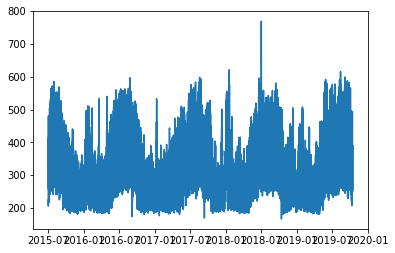

In [60]:
plt.plot(tal_uni)

In [3]:
X = tal_uni.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=320.083276, mean2=327.407323
variance1=6798.039141, variance2=7582.855291


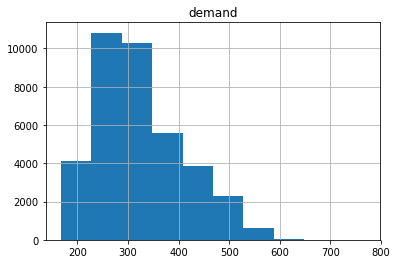

In [4]:
tal_uni.hist()
plt.show()

the distribution of values does not look like a Gaussian, therefore the mean and variance values are less meaningful. A log transform can be used to flatten out exponential change back to a linear relationship. Below is the same histogram with a log transform of the time series.

In [5]:
# we see the more familiar Gaussian-like or Uniform-like distribution of values.
X = tal_uni.values.copy()

mean1=5.736737, mean2=5.757274
variance1=0.062973, variance2=0.067068


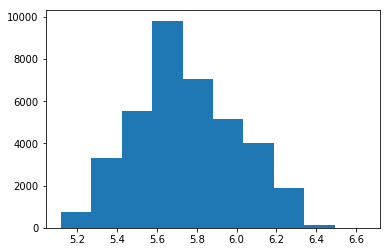

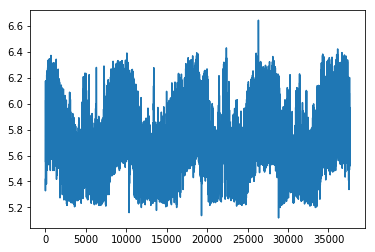

In [6]:
# we see the more familiar Gaussian-like or Uniform-like distribution of values.
X = tal_uni.values.copy()
X = np.log(X)
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))
plt.hist(X)
plt.show()
plt.plot(X)
plt.show()

### The mean and variance are very close for this split. This suggest stationary time series. However we might expect the daily, monthly seasonality there. To verify our guess we need to implement robust statistical test.

## Test 1: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
The null hypothesis of KPSS test is that the series are stationary. 

In [7]:
from statsmodels.tsa.stattools import kpss
X = tal_uni.values.flatten()
result = kpss(X)
print('KPSS Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 2.061756
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


## The test statistic is much bigger than the 1% critical value, indicating that the null hypothesis is rejected. That is, the data are not stationary. We can difference the data, and apply the test again.

In [8]:
# stationarity test on the differenced data
# convert the differenced dataframe to 1d array using flatten()
X = tal_uni.diff().dropna().values.flatten()

result = kpss(X)
print('KPSS Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.001987
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


### The p-value is 0.10 larger than the critical value 0.05. This time we cannot reject the hypthesis. We can conclude the differenced data are stationary.  That indicates the order of differencing to be d=1.

## Test 2:  Augmented Dickey-Fuller (ADF) test
### The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

In [10]:
from statsmodels.tsa.stattools import adfuller
X = tal_uni.values.flatten()
result = adfuller(X)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.309964
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### We got p-value equal to 0. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. We got a different result than KPSS test. 

## 10.2 Check the ACF/PACF plots

i) on the original data 

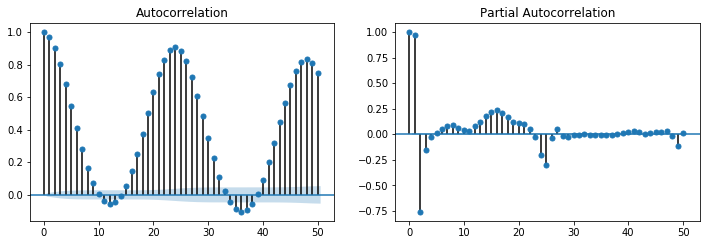

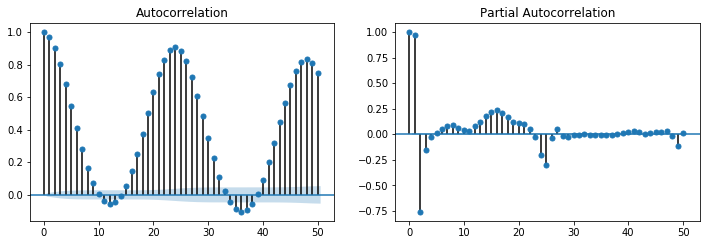

In [11]:
# figure for subplots
plt.figure(figsize = (12, 8))
# acf and pacf for demand
plt.subplot(221); plot_acf(tal_uni, lags = 50, ax = plt.gca())
plt.subplot(222); plot_pacf(tal_uni, lags = 50, ax = plt.gca())

### From ACF plot we saw recognized the cyclic pattern/ seasonality inside. From PACF we can say the order of AR term(p) should be equal to 3, which crosses the significant limit. 

ii) on the differenced data

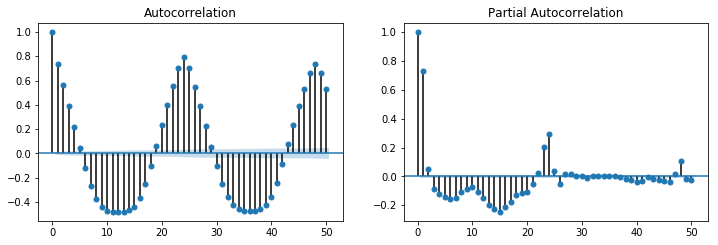

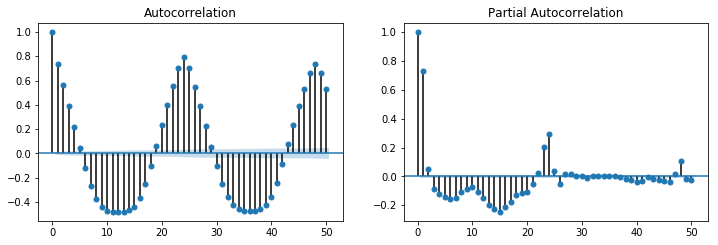

In [12]:
# figure for subplots
plt.figure(figsize = (12, 8))
# acf and pacf for demand
plt.subplot(221); plot_acf(tal_uni.diff(1).dropna(), lags = 50, ax = plt.gca())
plt.subplot(222); plot_pacf(tal_uni.diff(1).dropna(), lags = 50, ax = plt.gca())

The ACF in the first image clearly shows an daily seasonal trend. Peaks every 24 hours lag at about 24, etc.
Since, we observe daily seasonality

## 10.3 SARIMA Model

First, we fit an ARIMA(3,1,0) model. This sets the lag value to 3 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0. 

In [13]:

y = tal_uni.values

## Adf Test
#ndiffs(y, test='adf')  # 0

# KPSS test
#ndiffs(y, test='kpss')  # 1

# PP test:
ndiffs(y, test='pp')  # 0

0

In [16]:
def optimizeSARIMA(parameters_list, d, D, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train.demand, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(tal_uni, start_p=1, start_q=1,
                         #test='adf',
                         max_p=2, max_q=2, m=12,
                         start_P=0, 
                         seasonal=True,
                         d=1, 
                         D=1, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

In [ ]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(tal_uni, start_p=1, start_q=1,
                         #test='adf',
                         max_p=2, max_q=2, m=12,
                         start_P=0, 
                         seasonal=True,
                         d=1, 
                         D=1, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=298291.773, BIC=298334.450, Fit time=178.484 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=373155.186, BIC=373172.256, Fit time=4.529 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=296704.618, BIC=296738.759, Fit time=87.152 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=311318.346, BIC=311352.488, Fit time=188.160 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=331249.223, BIC=331274.829, Fit time=5.547 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=296595.125, BIC=296637.802, Fit time=335.217 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=291412.368, BIC=291463.580, Fit time=674.113 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=292844.835, BIC=292887.512, Fit time=474.356 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=291227.032, BIC=291286.779, Fit 

The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.
The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

### The best model parameters gave us ARIMA(2,1,1)(2,1,1)12 with lowest AIC 289548.508. We recognized that the running time for the model is sometimes so long, 1125.741 seconds that is 18.7 minutes. In next steps we have to walk forward method/ rolling forecast to forecast the test dataset. The model has to be retrained after each forecast after the addition of the next sample from the test set to the training set.  In our previous analysis we use the last year as the test set, that is 8760 records. If we run rolling forecast, that means we will create 8760 models. Each model takes about 18 minutes, that is 2628 hours to run all on the test set. This is too computational expensive which we cannot afford. 


In [14]:
n_test = 1 * 24 # test only on 24 hours 
train, test = tal_uni.iloc[0:-n_test], tal_uni.iloc[-n_test:]

In [23]:
# fit model
model = SARIMAX(train, order=(2,1,1), seasonal_order=(2,1,1,12))
model_fit = model.fit(disp=0)
# summary of fit model 
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                28875
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood             -112096.722
Date:                            Tue, 26 Nov 2019   AIC                         224207.444
Time:                                    13:22:30   BIC                         224265.336
Sample:                                07-01-2015   HQIC                        224226.053
                                     - 10-16-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1268      0.001    916.035      0.000       1.124       1.129
ar.L2         -0.2109      0.002   

### From the table above, the P Values of the AR1, AR2, MAL1,ar.s.L12, ar.S.L24,ma.S.l12 terms are highly significant (<< 0.05).

In [30]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(test):
    # prepare training dataset
   # n_test = int(1*24*1)   # set the test size 
    #train, test = X[0:-n_test], X[-n_test:]
    #history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
       # model = SARIMAX(history, order=(2,1,1), seasonal_order=(2,1,1,12))   #ARIMA(2,1,1)(2,1,1)12
        #model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        #history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('RMSE: %f'% rmse)
    return rmse

In [34]:
#X = tal_uni.values
evaluate_arima_model(test)

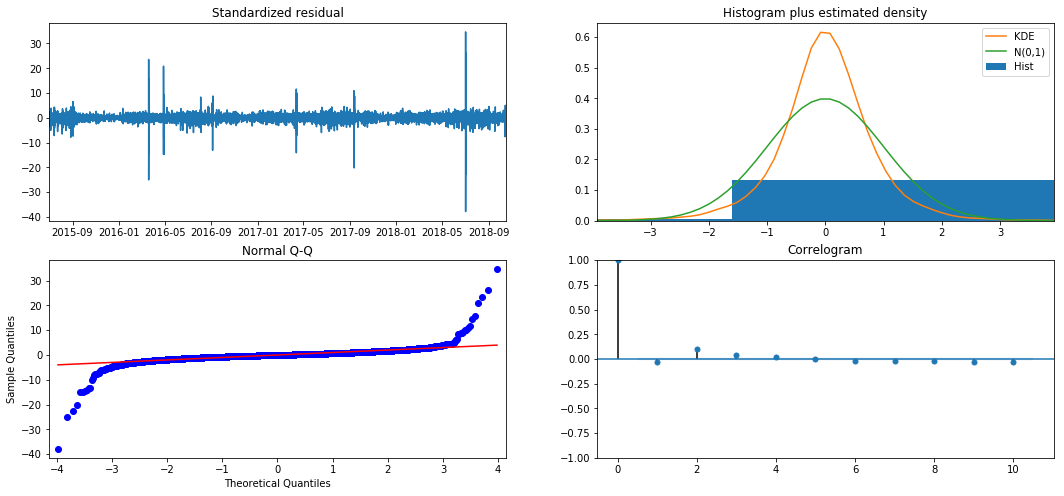

In [31]:
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

In [24]:
# Forecast
yhat = model_fit.forecast(24)  # 95% conf 

In [25]:
yhat

2018-10-16 04:00:00    251.722566
2018-10-16 05:00:00    252.741608
2018-10-16 06:00:00    258.247336
2018-10-16 07:00:00    282.114812
2018-10-16 08:00:00    304.815176
2018-10-16 09:00:00    314.414672
2018-10-16 10:00:00    334.440574
2018-10-16 11:00:00    361.907353
2018-10-16 12:00:00    392.108555
2018-10-16 13:00:00    419.756660
2018-10-16 14:00:00    443.911434
2018-10-16 15:00:00    465.572656
2018-10-16 16:00:00    478.521115
2018-10-16 17:00:00    483.761528
2018-10-16 18:00:00    476.546338
2018-10-16 19:00:00    458.666872
2018-10-16 20:00:00    452.405508
2018-10-16 21:00:00    433.624604
2018-10-16 22:00:00    400.160308
2018-10-16 23:00:00    364.049366
2018-10-17 00:00:00    327.097922
2018-10-17 01:00:00    297.213166
2018-10-17 02:00:00    274.928857
2018-10-17 03:00:00    260.713445
Freq: H, dtype: float64

In [33]:
rmse_sarima = np.sqrt(mean_squared_error(test.iloc[:24],fc_series))
rmse_sarima

11.43382825908189

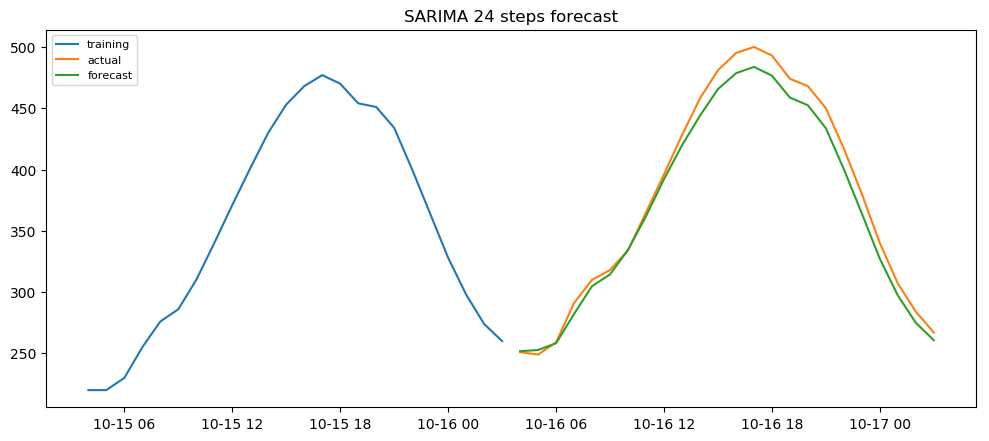

In [26]:
# Make as pandas series
fc_series = pd.Series(yhat, index=test.iloc[:24].index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.iloc[-24:], label='training')
plt.plot(test.iloc[:24], label='actual')
plt.plot(fc_series , label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
plt.title('SARIMA 24 steps forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [370]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

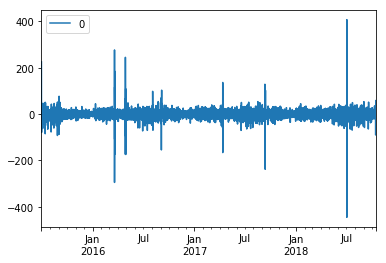

In [36]:
# line plot of residuals
residuals_arima = pd.DataFrame(model_fit.resid) 
residuals_arima.plot()
plt.show()

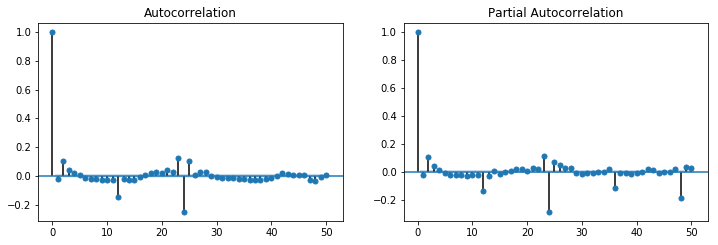

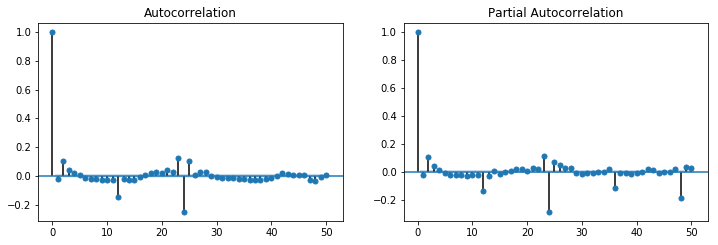

In [37]:
# figure for subplots
plt.figure(figsize = (12, 8))
# acf and pacf for demand
plt.subplot(221); plot_acf(residuals_arima, lags = 50, ax = plt.gca())
plt.subplot(222); plot_pacf(residuals_arima, lags = 50, ax = plt.gca())

In [38]:
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(disp = 0)
yhat =model_fit.predict(start=len(X), end=len(X), typ='levels')


rmse = np.sqrt(mean_squared_error(test_A, yhat))
   

NameError: name 'test_A' is not defined

In [43]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [41]:
# seasonal difference
#X = tal_uni
days_in_year = 24
differenced = tal_uni.diff(24).dropna().values

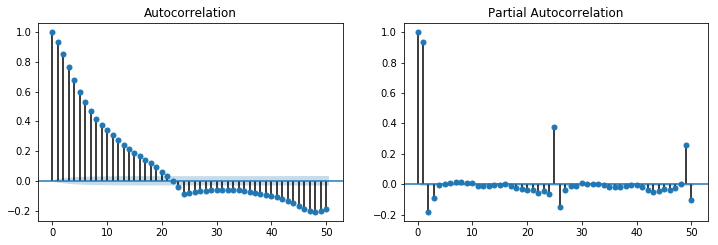

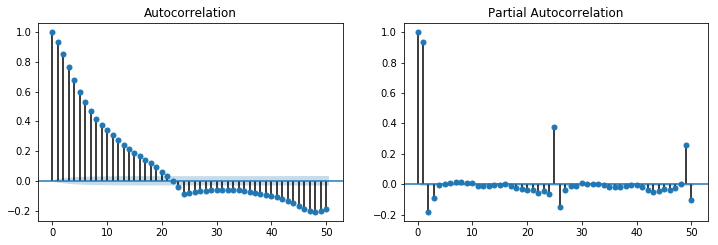

In [42]:
# figure for subplots
plt.figure(figsize = (12, 8))
# acf and pacf for demand
plt.subplot(221); plot_acf(differenced, lags = 50, ax = plt.gca())
plt.subplot(222); plot_pacf(differenced, lags = 50, ax = plt.gca())

In [57]:
forecast

array([   4.9101094 ,    6.89671248,    6.59160006,    6.47981318,
         16.31270168,   39.40300181,   32.11184508,   -2.50346872,
        -24.40804116,  -40.30204228,  -71.93561539,  -88.93997677,
        -95.81133493,  -90.96985725, -120.94763122, -106.4984511 ,
        -76.74784917,  -31.52070974,  -17.92791073,  -24.43864228,
        -24.69398306,  -11.04179559,    3.70223418,    1.35692155])

In [59]:
forecast

array([0.49764752, 0.72879335, 0.8100434 , 0.80956817, 0.76690855,
       0.70472279, 0.63574849, 0.56692424, 0.50182573, 0.44210225,
       0.3883207 , 0.34045891, 0.29819163, 0.26105432, 0.22853512,
       0.20012488, 0.17534281, 0.15374827, 0.13494472, 0.11857941,
       0.1043409 , 0.09195559, 0.08118395, 0.07181673])

In [58]:
# seasonal difference
X = tal_uni.values
hours_of_day = 24
differenced = tal_uni.diff(24).dropna().values
# fit model
model = ARIMA(differenced, order=(2,0,1))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 23
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
hour = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, hours_of_day)
	print('hour %d: %f' % (hour, inverted))
	history.append(inverted)
	hour += 1

hour 1: 250.497648
hour 2: 249.728793
hour 3: 262.810043
hour 4: 297.809568
hour 5: 339.766909
hour 6: 342.704723
hour 7: 337.635748
hour 8: 344.566924
hour 9: 358.501826
hour 10: 358.442102
hour 11: 363.388321
hour 12: 374.340459
hour 13: 387.298192
hour 14: 362.261054
hour 15: 378.228535
hour 16: 377.200125
hour 17: 392.175343
hour 18: 388.153748
hour 19: 363.134945
hour 20: 337.118579
hour 21: 314.104341
hour 22: 288.091956
hour 23: 269.081184
hour 24: 257.071817


In [55]:
len(history)

37659

In [56]:
len(X)

37635